## Hierarchical Bayesian Modeling to assess tribal knowledge

Our aim with this analysis is to create a methodology and a set of data-driven metrics that can help us identify potential technological risks within an organization's IT landscape. This proof of concept focuses on various risk factors that could affect operational health and security and influence technical debt hidden in our IT landscape. These metrics provide a quantitative basis for a risk diagnostic and enable us to see the impact of making directly relevant choices to reducing these risks. 

For our analysis, we focus on 7 major factors and rationale as to why:

  - **Time Since Last Commit**: This metric indicates the recency of activity within a repository. Longer intervals since the last commit can suggest a project becomes dormant, highlighting potential maintenance or abandonment risks.
  - **Age of the Repo**: his metric reflects the age of the repository from its initial creation to the present day. While a newer repository might be in active development or just gaining traction, an older repository with sporadic updates may indicate a legacy system that's either stable with minimal changes needed or potentially neglected.
  - **Commit Frequency (CF)**: Regular commit activity shows ongoing development and maintenance. Low commit frequency can signal reduced development efforts or potential stagnation, implying operational risks.
  - **Open Issues Ratio (OIR)**: The ratio of open to closed issues offers insights into how effectively a project addresses bugs, requests, or security concerns. A high open issues ratio may indicate operational inefficiencies or backlogs that could escalate into security or functional risks.
  - **Pull Request Resolution Time (PRRT)**: The average time to close pull requests reflects the project's responsiveness and process efficiency. Longer resolution times may indicate bottlenecks in the development process, affecting the project's ability to respond promptly to emerging risks.
  - **Total Number of Languages in the Repo**: Projects utilizing a wide range of programming languages might face increased complexity, potentially raising the risk of integration issues, maintenance challenges, and a higher barrier for new contributors, which could affect long-term sustainability.
  - **Average Number of Commits per Month**: This metric provides an average rate of development activity over time, offering a more granulated view of the project's momentum. A declining trend may indicate a loss of development interest or a shift in focus, which could affect the project's vitality and risk profile.

### Composite Function and Problem-Solving Capability

When combined mathematically, the metrics above create a composite function that assesses risk across multiple dimensions. The model provides a comprehensive view of each repository's risk profile by combining these factors. This approach enables:

- **Prioritization of Risk Mitigation Efforts**: Repositories or projects exhibiting higher risk signals across these metrics can be prioritized for further investigation and remediation efforts.
- **Early Warning System:** Trends identified through these metrics can serve as early warnings for projects heading towards higher-risk states, allowing proactive interventions.
- **Strategic Decision Support**: By understanding the risk landscape across the IT estate, decision-makers can make informed strategic choices about resource allocation, project continuation, and architectural adjustments.

To understand the dynamics of these risks, we utilise Hierarchical Bayesian Modelling (HBM) as our analytical tool. HBM is adept at handling multi-level data, enabling us to dissect the layers of risk present in individual repositories and across the organisation as a whole.  For instance, a decline in commit activity and an increase in outdated dependencies may indicate a repository becoming less active or potentially being deprecated.  Conversely, a consistent or improving security posture alongside these trends might indicate a repository reaching a stage of maturity, requiring fewer updates.  

#### Flow

We extract key risk metrics through the GitHub REST API to construct a hierarchical Bayesian model for assessing risk. These metrics are crucial for creating and understanding compound metrics for our repositories' operational and security risks.

**Data Collection and Preparation:** The initial step involves fetching and transforming data to construct these risk indicators across all repositories and owners via the GitHub API. This forms the base of our dataset, capturing a wide range of activities and potential vulnerabilities across the software development process.

**Model Construction:** Using PyMC, we then define a hierarchical model that mirrors the layered nature of our data. This model distinguishes the variability within individual repositories and the typical patterns observable across different owners. By affecting repository-level distributions through owner-level priors, the model aims to uncover both specific and general risk trends.

**Hierarchical Model Framework:**
- **Level 1 (Observations):** Integrates base metrics as the observable layer.
- **Level 2 (Risk Factors):** Introduces latent variables for different risk types (Operational Risk, Security Risk, Technical Debt) influenced by the Level 1 metrics.
- **Level 3 (Overall Risk):** Our model aggregates the Level 2 risk factors into a compound risk score, reflecting the overall risk impact on the IT estate.

**Inference and Analysis:** We sample from the posterior distribution by applying PyMC's MCMC methods to refine our model parameters. This allows us to investigate the posterior distributions and identify which languages or practices significantly deviate from the norm, marking them as potential risk areas.

This approach enables a structured exploration of how various risk components interact and influence the overall risk landscape. PyMC's flexibility facilitates scenario simulation, such as evaluating the impact of improving pull request resolution time (PRRT) on the overall risk. This rigorous analysis gives us detailed insights into our IT estate's risk profile, supporting strategic decision-making and focused risk mitigation efforts.

In [ ]:
# Import required packages

import pandas as pd
import numpy as np
import pymc as pm
from datetime import datetime
from dateutil.relativedelta import relativedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

import arviz as az
import pprint 
from ridgeplot import ridgeplot
import subprocess 

from dotenv import load_dotenv
import os

from tribal_knowledge.utils import LanguagePosteriorAnalysis
from tribal_knowledge.repo_crawler import GitHubRepositoryInfoExtractor, PandasOutputFormat
from github import Github
from github.PaginatedList import PaginatedList
from github.StatsCommitActivity import StatsCommitActivity
from github.StatsParticipation import StatsParticipation

## Data Collection

We have enabled two options to get data, 
  * Option 1: Using dummy data - This data is a copy of some data from the GitHub REST service and processed to have the same output as the data from the `RepoCrawler` class for the OWNER Apache.
  * Option 2: We use the `RepoCrawler` class to pull data, and fields of interest are left to the user to define. This option requires a user to set a GitHub token.

To use the second option, a personal access token must be given to the RepoCrawler (https://docs.github.com/en/enterprise-server@3.9/authentication/keeping-your-account-and-data-secure/managing-your-personal-access-tokens)


In [ ]:
# Attempt to get the value of GITHUB_API_TOKEN environment variable - USER must set this either as global env var or you can set in a .env file
load_dotenv('.env')
github_api_token = os.environ.get('GITHUB_API_TOKEN')

if github_api_token:
    print("GITHUB_API_TOKEN retrieved")
else:
    print("GITHUB_API_TOKEN is not set.")

Depending on whether we receive a token, we will fetch data from a specified repository or load the dummy data. In this example, we will parse the Apache Foundation GitHub repository, which has around 3,000 repositories, and retrieve the programming language bytes and the number of stargazers for each repository.

We've selected made use of the REST API in order to receive data for understanding the various dimensions of risk across repositories:

To calculate *Commit Frequency* (CF) and *Average Number of Commits per Month*, we utilise the `get_stats_commit_activity` method. This method fetches data on commit activity over the past year, providing a basis for assessing repository maintenance and development momentum.

*Time Since Last Commit* is inferred from the latest activity data obtained via `get_stats_participation`. While this method offers a broad stroke of engagement, pinpointing the exact date of the last commit may require calculation on the timestamps.

The *Open Issues Ratio* (OIR) calculation relies on data from `get_issues` with the state set to "open". Completing this metric's calculation requires additional processing to contrast open against closed issues.

*Pull Request Resolution Time* (PRRT) is determined by analysing data from `get_pulls` with the state as "all". This involves calculating the duration between the creation and closure of pull requests, which tells us the efficiency of the project's review and integration processes.

The *Total Number of Languages* in the Repo is directly fetched using `get_languages`, offering insights into the project's complexity and the diversity of its technological stack.

In [ ]:
if github_api_token:
        # Only use 4 workers to make sure we don't hit rate limits
        with GitHubRepositoryInfoExtractor(access_token=github_api_token, max_workers=4) as extractor:
            owners = ['apache']
            repos = extractor.fetch_repositories(identifiers=owners)
        
            # Details specification for fetching properties and invoking methods
            details_spec = {
                "properties": ["created_at"],
                "methods": {
                    "get_stats_commit_activity": {},
                    "get_stats_participation": {},
                    "get_issues": {"state": "all"},
                    "get_pulls": {"state": "all"},
                    "get_languages": {}
                }
            }
            # Fetch repository details for the first 25 repositories
            repo_attributes = extractor.fetch_repository_details(repos=repos[:500], details_spec=details_spec)
            #repo_attributes = extractor.fetch_repository_details(repos=repos, details_spec=details_spec)
else:
    print("To implement reading dummy data")

GitHub's API methods through PyGithub are successful; the raw objects returned by these calls are directly stored in the results dictionary. This is typical behaviour when working with PyGithub, as the library returns specialised objects for API responses, which include paginated lists for iterable results (like issues or pull requests) and custom objects for structured data (like commit activities or language statistics).

Let's unpack these to be a little more useful

In [ ]:
def count_paginated_items(paginated_list, condition=lambda x: True):
    """Count items in a PaginatedList that meet the given condition."""
    return sum(1 for item in paginated_list if condition(item))

def process_repository_details(repo_name, repo_data):
    processed_data = {}
    
    # Handle created_at date
    if "created_at" in repo_data:
        created_at = repo_data["created_at"]
        current_date = datetime.now(created_at.tzinfo)
        age_days = (current_date - created_at).days
        processed_data["age_in_days"] = age_days

    # Handle languages
    if "get_languages" in repo_data:
        languages = repo_data.get("get_languages", {})
        total_bytes = sum(languages.values())
        total_languages = len(languages.keys())
        processed_data["total_language_bytes"] = total_bytes
        processed_data["total_languages"] = total_languages

    # Handling issues
    if "get_issues" in repo_data:
        if isinstance(repo_data["get_issues"], PaginatedList):
            issues = repo_data["get_issues"]
            open_issues_count = count_paginated_items(issues, condition=lambda x: x.state == "open")
            closed_issues_count = count_paginated_items(issues, condition=lambda x: x.state == "closed")
            total_issues = open_issues_count + closed_issues_count
            open_issues_ratio = open_issues_count / total_issues if total_issues > 0 else 0
            processed_data["open_issues_ratio"] = open_issues_ratio
            processed_data["open_issues_count"] = open_issues_count
            processed_data["closed_issues_count"] = closed_issues_count

    # Handling pulls 
    if "get_pulls" in repo_data:
        if isinstance(repo_data["get_pulls"], PaginatedList):
            pulls = repo_data["get_pulls"]
            merged_pulls_count = sum(1 for pull in pulls if pull.merged_at is not None)
            processed_data["merged_pulls_count"] = merged_pulls_count

    # Handling commit 
    if "get_stats_commit_activity" in repo_data:
        if isinstance(repo_data["get_stats_commit_activity"], list):
            commit_activity = repo_data["get_stats_commit_activity"]
            total_commits_last_year = sum(activity.total for activity in commit_activity)
            processed_data["total_commits_last_year"] = total_commits_last_year

    # Handling participation
    if "get_stats_participation" in repo_data:
        if isinstance(repo_data["get_stats_participation"], StatsParticipation):
            participation = repo_data["get_stats_participation"]
            total_commits = sum(participation.all)
            processed_data["total_commits_participation"] = total_commits

    return repo_name, processed_data


def process_all_repositories(repo_attributes):
    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_repo = {executor.submit(process_repository_details, repo_name, repo_data): repo_name for repo_name, repo_data in repo_attributes.items()}
        progress = tqdm(as_completed(future_to_repo), total=len(repo_attributes), desc="Processing Repositories")

        for future in progress:
            repo_name = future_to_repo[future]
            try:
                _, processed_data = future.result()
                repo_attributes[repo_name].update(processed_data)
            except Exception as exc:
                print(f'{repo_name} generated an exception: {exc}')
    return repo_attributes




In [ ]:
# Lets process things.
repo_attributes = process_all_repositories(repo_attributes)

In [ ]:
# Use the PandasOutputStrategy to convert the attributes to a pandas DataFrame
pandas_output = PandasOutputStrategy()
df = pandas_output.transform(repo_attributes)
# Rename the 'Value' column to 'ByteCount'
df = df.rename(columns={'Value': 'ByteCount'})
df = df.rename(columns={'get_languages': 'Language'})

print(df.head())

# filter out languages that only appear less than 10 times
language_counts = df['Language'].value_counts()
languages_at_least_n = language_counts[language_counts >= 50].index.tolist()
df = df[df['Language'].isin(languages_at_least_n)]


# Calculate the logarithm of the ByteCount column for later use in the model
df['logByteCount'] = np.log(df['ByteCount'])

# Create a new column 'Unique_Repo' by concatenating 'Owner' and 'Repository' columns
df['Unique_Repo'] = df['Owner'] + "_" + df['Repository']

# Columns to encode into categorical codes
columns_to_encode = ['Owner', 'Language', 'Repository', 'Unique_Repo']

# Encode each column to categorical codes
for column_name in columns_to_encode:
    df[f'{column_name}_codes'] = df[column_name].astype('category').cat.codes

# Create a compound key for each language within each repository
df['Repo_Lang_Key'] = df['Unique_Repo_codes'].astype(str) + '_' + df['Language_codes'].astype(str)

# Encode the compound key into unique categorical codes
df['Repo_Lang_Key_codes'] = df['Repo_Lang_Key'].astype('category').cat.codes

# Display the total number of unique Owners and unique repository IDs for verification
print("Total number of Owners:", df['Owner'].nunique())
print("Total number of unique repository IDs:", df['Unique_Repo_codes'].nunique())
print("Total number of unique language-repository combinations:", df['Repo_Lang_Key_codes'].nunique())
print("Total number of unique language IDs:", df['Language'].nunique())
print(df['Language'].value_counts())


In [ ]:
# Group by 'Language' and create a list of log byte counts for each language
grouped = df.groupby('Language')['logByteCount'].apply(list).to_dict()

# Prepare samples for ridge plot
samples = [np.array(grouped[language]) for language in grouped]
fig = ridgeplot(samples=samples, labels=list(grouped.keys()), colorscale="viridis", colormode="row-index",)
fig.update_layout(height=1250, width=800)

fig.show()

### Reduced sample connectins

Below we show what the connections between Owner s, repos and languagues an look like, (generated via neo4j using `output_cypher_file.cypher`)

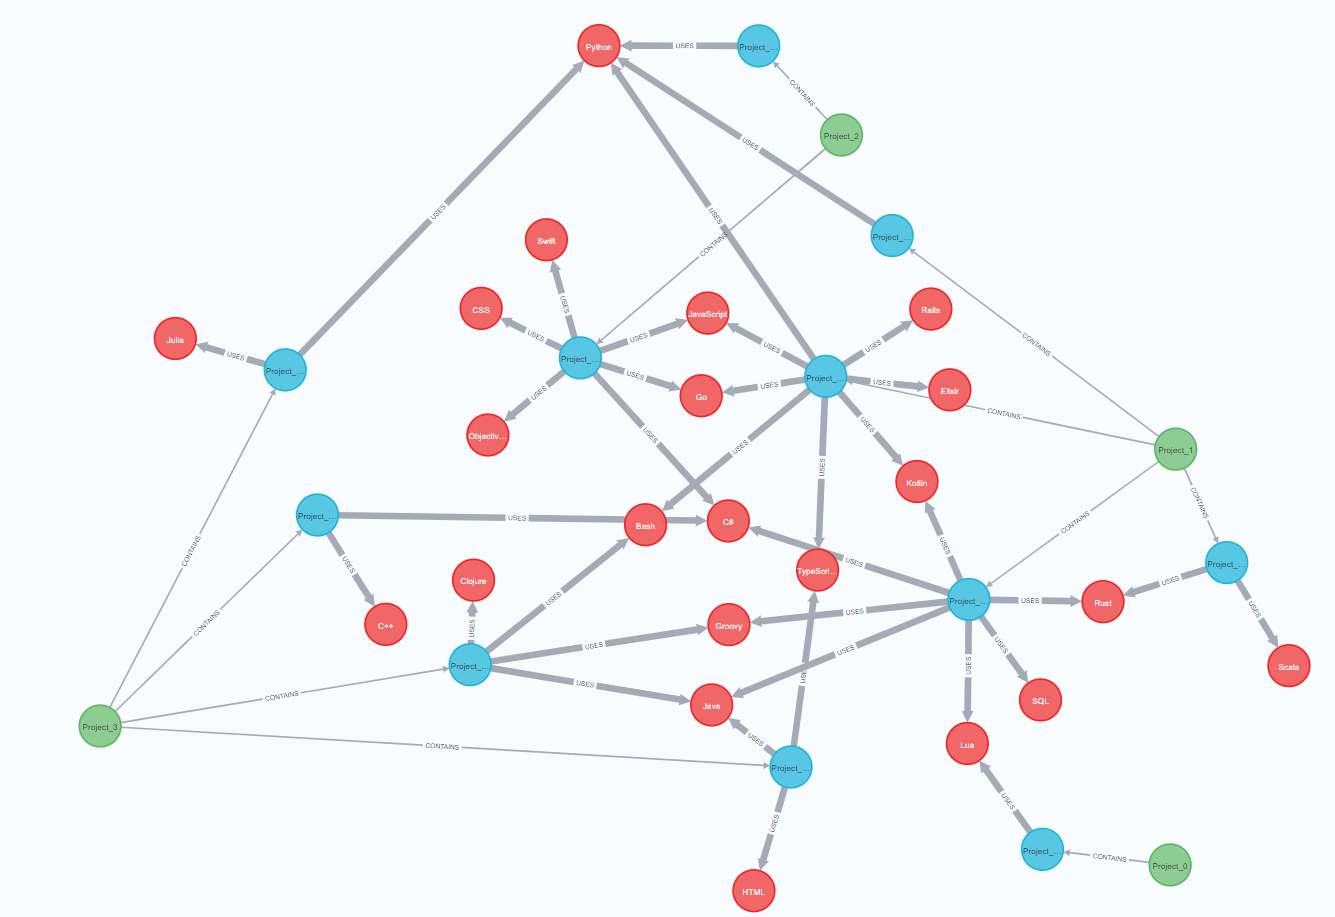

## Hierarchical Model Specification

This section introduces Hierarchical Bayesian Modelling (HBM) principles and their application in structuring complex, multi-level datasets, such as those encountered in evaluating technological risks within coding languages.

#### Introduction to Hierarchical Bayesian Modelling
Hierarchical Bayesian Modelling is a statistical framework that facilitates data analysis across different levels of hierarchy by integrating the variability within individual units, such as repositories, and observing commonalities that may emerge. At the core of Bayesian inference is Bayes' theorem, which updates the probability for a hypothesis by introducing new evidence. A fundamental concept in HBM is exchangeability, suggesting that data points are probabilistically interchangeable. This characteristic makes it particularly suited for modelling datasets without a natural ordering but considered identically distributed given some parameters.

Our analysis delves into programming language usage within repositories, examining the ByteCount—the code volume per language in each repository. We adopt distributions like the Negative Binomial to model count data, framing our approach as a Hierarchical Negative Binomial Model. This model explicitly addresses the intricacies of language usage within repositories, adding a novel layer by considering the impact of language diversity per repository on language prevalence.

- **Repository-Level Language likelihood:** The effects of specific programming languages within repositories are central to our analysis. We model these effects to capture the observed code volume across languages, incorporating a likelihood function that accounts for data variability and dispersion:

$$ P(Language_{ij} | \theta_{ij}) \sim NegativeBinomial(\mu_{ij}, \alpha)$$

  Here, $\\theta_{ij}$ represents the expected byte count for language usage, where $i$ denotes the repository and $j$ is the language. $\\mu_{ij}$ is the mean parameter, and $\\alpha$ is the dispersion parameter of the Negative Binomial distribution, modelling the count data's overdispersion within each repository for each language.

- **Language Count Priors:**  Reflecting our initial beliefs about code distribution across programming languages within repositories, our model establishes language count priors:

$$ \mu_i \sim LogNormal(\log(\mu), \sigma^2) $$

  This LogNormal distribution for $\\mu_i$ allows us to model the mean language counts on a log scale, accommodating the wide range of byte counts observed across languages.

- **Language Diversity and Interaction Effects:** A novel aspect of our model focuses on the total number of programming languages present in each repository and their influence on the prevalence of specific languages. This analysis allows us to explore whether repositories with a greater variety of languages exhibit distinct patterns in language usage compared to those with fewer languages.
    $$log\_mu = \log(diversity\_effect_{i} + language\_effect_{j})$$
where
    - **Diversity Effect:** The effect of language diversity within repositories is modelled quantitatively to predict the prevalence of specific languages. We hypothesise that a higher diversity of languages might correlate with unique language patterns, which is captured by the following equation:
    $$ diversity\_effect \sim Normal(0, \sigma_{diversity}) $$
      
    - **Inferred Interaction Effects:** Our model infers interactions between languages based on their co-occurrence within repositories to capture the nuanced dynamics of language co-occurrence. This approach allows for identifying emergent patterns not explicitly defined by predefined affinities but discovered through data analysis. The inferred interaction effects can be conceptually represented as:
    $$ interaction\_effect \sim Normal(0, \sigma_{interaction}) $$

The inclusion of language diversity and the potential for inferred interaction effects between languages are modelled implicitly within the log_mu formulation. This allows us to explore how diverse language environments within repositories might influence the prevalence of specific languages, either amplifying or mitigating their usage based on the repository's unique language composition.    
   
  
- **Organisational-Level Hyperpriors**

To enhance our repository-level analysis, we incorporate organisational-level hyperpriors. These hyperpriors play a crucial role in deciphering broad patterns of programming language utilisation across the entire organisational spectrum, covering all Owners and repositories. By introducing hyperpriors for the mean and dispersion of language usage organisation-wide, we delve into the depths of the organisational programming language landscape, unveiling insights into commonalities and variances that permeate the organisation.

- **Modeling Mean Language Usage Across the Organisation with a Beta Distribution**

  The mean language usage across the organisation is modelled using a Beta distribution. This choice reflects our understanding that rates of programming language usage can be effectively represented as proportions within the [0,1] range. The flexibility of the Beta distribution makes it ideally suited for capturing the varied prevalence of programming languages across repositories. The mean language usage is defined by:

  $$\mu_i \sim Beta(a_{\mu}, b_{\mu})$$

  where $a_{\mu}$ and $b_{\mu}$ are the shape parameters of the Beta distribution. These parameters guide our beliefs about the distribution of mean language usage across the organisation, providing a foundation for analysing language trends.

- **Dispersion in Language Usage**

  The dispersion in language usage, reflecting the variability or concentration of language distribution organisation-wide, is modelled using a Gamma distribution. This approach accommodates both concentrated and dispersed patterns of language usage, capturing the essence of variability in language patterns across the organisation:

  $$\kappa_i \sim Gamma(a_{\kappa}, b_{\kappa})$$

  The parameters $a_{\kappa}$ and $b_{\kappa}$ are specifically chosen to reflect the observed spread in language utilisation, ensuring the model accurately represents the range of distributions from concentrated to broadly dispersed. Integrating this dispersion parameter into our hierarchical Bayesian model enhances our understanding of the dynamics governing programming language prevalence and variability within the organisational context.

#### An English Explanation of Our Model

- **Negative Binomial Distribution for Count Data:** The model employs the Negative Binomial distribution to accurately reflect the variability in the number of bytes of code (ByteCount) across different programming languages in each repository. This choice addresses the common overdispersion in code volume data, allowing for a more realistic representation of code distribution patterns.

- **Model Components:**

  - **Language Likelihood at the Repository Level:** This component assesses the likelihood of encountering specific volumes of code in various languages within each repository. It accounts for both the average volume of code (mean) and the variability (variance) in these volumes, acknowledging the significant differences that can exist not only between languages but also within the same language across different repositories.

  - **Language Count Priors:** The model establishes baseline assumptions regarding code distribution across programming languages within repositories, employing a LogNormal distribution. This choice reflects the expectation that code volumes can span a broad range, with some languages potentially having significantly more significant amounts of code. The LogNormal distribution is suited for capturing this wide range, especially on a logarithmic scale, where the distribution of code volumes is presumed to be skewed.

  - **Language Diversity and Interaction Effects:** A key innovation of the model is its attention to the diversity of programming languages present within a repository and the potential interactions between these languages. It posits that repositories featuring a more comprehensive array of languages may demonstrate distinct language usage patterns compared to those with fewer languages. The model captures these dynamics through a composite effect ($log_{mu}$), which integrates the influence of language diversity and the interactions between languages that co-occur within repositories.

  - **Organizational-Level Hyperpriors:** Extending its analysis beyond the scope of individual repositories, the model integrates organisational-level hyperpriors to discern overarching patterns of programming language use throughout the entire organisation. These hyperpriors, informed by distributions such as the Beta for mean language usage and the Gamma for dispersion in language usage, enable the model to capture broad trends and variabilities in language distribution across the organisation. This holistic view facilitates the identification of widespread language usage patterns, potential areas for technology adoption, and the detection of language-specific knowledge silos.

- **Objective of the Model:** The main goal of this model is to provide useful insights into an organization's technological ecosystem by analyzing the usage of programming languages at both micro (repository) and macro (organizational) levels. By examining programming languages, the model aims to identify areas that could benefit from strategic intervention, risk management, and resource optimization. The model uses a hierarchical Bayesian framework to identify dominant languages and examine the nuances of language diversity and interaction, providing a comprehensive understanding of the organization's coding practices. This, in turn, can help foster innovation, improve efficiency, and guide technological strategy.


## Transitioning to Posterior Distributions

### From Theory to Practice: The Role of Posterior Distributions

With our model parameters defined and their priors set, the next step in Bayesian analysis is to update these beliefs with observed data. This is where the posterior distribution comes into play.


#### What is the posterior?

In the hierarchical Bayesian modelling (HBM) context, the posterior distribution is the updated belief about our model's parameters after considering the observed data. It combines our prior beliefs (the priors) and the evidence from the data (the likelihood). Mathematically, it is expressed as:

$$
P(\theta | data) \propto P(data | \theta) \times P(\theta)
$$

Where:
- \($ P(\theta | data) $\) is the posterior distribution of the parameters \($ \theta $\).
- \($ P(data | \theta) $\) is the likelihood of the data given the parameters.
- \($ P(\theta) $\) is the prior distribution of the parameters.

After observing the data, the posterior distribution provides a range of likely values for the parameters, which is crucial for making informed decisions.


### Practical Implications of Posterior Analysis in Hierarchical Bayesian Modelling
### Informing Strategic Decision-Making

The power of posterior analysis extends beyond diagnostics; it informs strategic resource allocation and risk management:

- **Credible Intervals**: The precision of parameter estimates, reflected in the credible intervals of the posterior distribution, directs our focus to areas where additional data collection or deeper investigation may be warranted.

- **Outlier Detection**: Spotting outliers within posterior distributions alerts us to unconventional language usage patterns. These could represent areas of innovation warranting further exploration or potential risks if the languages in question lack broad support.

- **Strategic Resource Allocation**: Insights gained from posterior distributions enable informed decisions on resource allocation—be it for targeted training programmes, strategic hiring to build expertise in underutilised languages, or investment in technology stacks that promise to align with and propel the organisation's strategic objectives.

Interpreting the posterior distributions derived from our hierarchical model does more than just enhance our understanding of language usage; it equips us to forecast, plan, and foster a coding environment that is both efficient and resilient to future challenges.

### Uncovering Knowledge Silos

The posterior distributions for language usage within repositories serve as a diagnostic tool, revealing languages that are disproportionately relied upon. Anomalies in these distributions may signal the existence of knowledge silos, suggesting areas where diversification and training could be beneficial. By identifying these silos, we can proactively address potential bottlenecks in knowledge transfer and code maintenance.

### Evaluating Organisational Coding Norms

At the highest organisational level, posterior distributions offer a macro perspective of coding culture and norms. Deviations in these distributions can reveal organisational preferences or aversions towards specific languages. Understanding these trends is critical for shaping future strategies in technology adoption, capability development, and training initiatives.


## Model Implementation
- Implementing the HBM using PyMC3
- Defining the model in PyMC3
- Setting up the priors for each level of the hierarchy
- Incorporating the data into the model
- Model fitting (e.g., using MCMC methods)

In [ ]:
n_Owners = df['Owner_codes'].nunique()
# Update to use the 'Unique_Repo_codes' for repository count since it's already unique across Owners
n_repositories = df['Unique_Repo_codes'].nunique()

# Continue using 'Language_codes' for language count as it remains valid
n_languages = df['Language_codes'].nunique()
language_idx = df['Language_codes'].values
repository_idx = df['Unique_Repo_codes'].values

# Calculate the mean byte count for each language across all repositories
# Ensure aggregated_language_effect_means is ordered according to Language_codes
aggregated_language_effect_means = df.groupby('Language_codes')['ByteCount'].mean().sort_index().values

# Calculate the number of unique language-repository combinations instead
n_language_repo_combinations = df['Repo_Lang_Key_codes'].nunique()
language_repo_idx = df['Repo_Lang_Key_codes'].values

# Byte count remains the same as it's tied to the unique language-repository combination
byte_count = df['ByteCount'].values

print(f'n_Owners: {n_Owners}, n_repositories: {n_repositories}, n_languages: {n_languages}')
print(f'language_repo_idx shape: {language_repo_idx.shape}, byte_count shape: {byte_count.shape}')
print(df.head())


In [ ]:
# Leveraging existing data to inform prior distributions in a PyMC model can significantly improve model convergence and accuracy by providing more informed starting points for the sampling process.
# We can identify several aspects where initial values can be informed by our dataset:

# Average logByteCount per language as a starting point for language_effect_mu
average_logByteCount_per_language = df.groupby('Language')['logByteCount'].mean()

# Count of unique languages per repository
languages_per_repo = df.groupby('Repository')['Language'].nunique()
# Average number of languages per repository
avg_languages_per_repo = languages_per_repo.mean()

mean_data = df['logByteCount'].mean()
var_data = df['logByteCount'].var()

# Calculate alpha_gamma and beta_gamma
alpha_gamma_estimate = mean_data ** 2 / var_data
beta_gamma_estimate = mean_data / var_data


with pm.Model() as language_usage_model:
    # Organizational-level hyperpriors remain as originally defined
    a_mu = pm.Gamma('a_mu', alpha=1.0, beta=1.0)
    b_mu = pm.Gamma('b_mu', alpha=1.0, beta=1.0)
    
    # Language effect priors with data-informed mean values
    language_effect_mu = pm.Normal('language_effect_mu', mu=average_logByteCount_per_language, sigma=pm.math.sqrt(1/a_mu), shape=n_languages)
    language_effect_sigma = pm.InverseGamma('language_effect_sigma', alpha=b_mu, beta=1.0, shape=n_languages)
    
    # Detailed modeling for language effects remains unchanged
    language_effect = pm.Normal('language_effect', mu=language_effect_mu[language_idx], sigma=language_effect_sigma[language_idx], shape=n_language_repo_combinations)

    # Gamma distribution parameters for languages per repo effect, now data-informed
    alpha_gamma = pm.Truncated('alpha_gamma', dist=pm.Exponential.dist(lam=1/alpha_gamma_estimate), lower=0.1, upper=None)
    beta_gamma = pm.Truncated('beta_gamma', dist=pm.Exponential.dist(lam=1/beta_gamma_estimate), lower=0.1, upper=None)
    
    languages_per_repo_effect = pm.Gamma('languages_per_repo_effect', alpha=alpha_gamma, beta=beta_gamma, shape=n_repositories)
    
    # Diversity effect priors also remain as in the original structure
    diversity_effect_mu = pm.Normal('diversity_effect_mu', mu=0, sigma=pm.math.sqrt(1/a_mu), shape=n_repositories)
    diversity_effect_sigma = pm.InverseGamma('diversity_effect_sigma', alpha=b_mu, beta=1.0, shape=n_repositories)
    diversity_effect = pm.Normal('diversity_effect', mu=diversity_effect_mu, sigma=diversity_effect_sigma, shape=n_repositories)
    
    
    # Combining effects to model expected byte counts, using language_repo_idx for detailed modelling
    log_mu = pm.Deterministic(
        'log_mu',
        language_effect[language_repo_idx] +  # Adjusted to use language_repo_idx
        languages_per_repo_effect[repository_idx] +  # Maintains repository-level effect
        diversity_effect[repository_idx]  # Maintains repository-level diversity effect
    )
    
    # Dispersion parameter
    alpha = pm.Exponential('alpha', 1.0, shape=n_repositories)
    
    # Negative Binomial for observed byte counts, adjusted for granularity
    language_count_obs = pm.NegativeBinomial(
        'language_count_obs',
        mu=np.exp(log_mu),
        alpha=alpha[repository_idx],  # Using repository_idx for dispersion as it's repository-specific
        observed=byte_count
    )


Here’s the graphical representation of the model.

In [ ]:
# Simple model for real data to work:
with pm.Model() as language_usage_model:
    # Fixed hyperparameters based on domain knowledge
    fixed_a_mu = 2.0
    fixed_b_mu = 0.5
    
    # Simplified language effect with data-informed priors and simpler variance distribution
    language_effect_mu = pm.Normal('language_effect_mu', mu=average_logByteCount_per_language, sigma=1, shape=n_languages)
    language_effect_sigma = pm.HalfNormal('language_effect_sigma', sigma=fixed_b_mu, shape=n_languages)
    
    # Core language effect
    language_effect = pm.Normal('language_effect', mu=language_effect_mu[language_idx], sigma=language_effect_sigma[language_idx], shape=n_language_repo_combinations)

    # Simplified observational model
    log_mu = pm.Deterministic('log_mu', language_effect[language_repo_idx])
    alpha = pm.Exponential('alpha', 1.0)
    
    # Adjusted Negative Binomial for observed byte counts
    language_count_obs = pm.NegativeBinomial('language_count_obs', mu=np.exp(log_mu), alpha=alpha, observed=byte_count)


In [ ]:
model_graph = pm.model_to_graphviz(language_usage_model)

# Customize the graph - Example changes
model_graph.attr(label='Hierarchical Language Usage Model\nBayesian Model Visualization')
model_graph.attr(fontsize='20', color='blue', fontname="Helvetica")

# Node and Edge customizations
with model_graph.subgraph() as s:
    s.attr(rank='same')
    # Customize nodes
    s.node_attr.update(color='lightblue2', style='filled', fontname="Helvetica")
    # Customize edges
    s.edge_attr.update(color='gray', arrowsize='0.5')

# Render the graph 
model_graph


In [ ]:
# Fiting the model - using nutpie for faster sampling

with language_usage_model:
    trace = pm.sample(500, tune=500, return_inferencedata=True, target_accept=0.95, nuts_sampler="blackjax")


### Results and Interpretation

This section guides you through extracting and interpreting the results of the hierarchical Bayesian model applied to programming language usage within an organisation. We'll focus on understanding the impact of various factors on language usage, visualise distributions across Owners and repositories, and identify potential outliers or areas of risk.

#### Identifying Outliers Based on Credible Intervals

Let's identify repositories whose observed language usage falls outside the credible intervals predicted by our model. These could be considered outliers.

In [ ]:
# Perform posterior predictive checks, which generate posterior predictive samples given a trace and a model:

with language_usage_model:
    ppc = pm.sample_posterior_predictive(trace)

In [ ]:
# Access the posterior_predictive group
posterior_predictive = ppc.posterior_predictive
summary_stats = az.summary(posterior_predictive, var_names=['language_count_obs'], hdi_prob=0.95)

# Assume byte_count is a list/array with the observed byte counts ordered as in your model
# This approach requires the model's indices to match the 'Repo_Lang_Key_codes' in 'df'
outliers = []

# Adding columns for CI lower, CI upper, and outlier flag directly to the df
df['CI_Lower'] = pd.NA
df['CI_Upper'] = pd.NA
df['Is_Outlier'] = False

for index, row in df.iterrows():
    repo_lang_key_code = row['Repo_Lang_Key_codes']
    ci_lower = summary_stats.loc[f"language_count_obs[{repo_lang_key_code}]", "hdi_2.5%"]
    ci_upper = summary_stats.loc[f"language_count_obs[{repo_lang_key_code}]", "hdi_97.5%"]
    
    # Update the DataFrame directly with CI values
    df.at[index, 'CI_Lower'] = ci_lower
    df.at[index, 'CI_Upper'] = ci_upper
    
    # Check if the current row's ByteCount is an outlier
    is_outlier = row['ByteCount'] < ci_lower or row['ByteCount'] > ci_upper
    df.at[index, 'Is_Outlier'] = is_outlier


print(f'Number of outlier Repo-Language combinations:, {df["Is_Outlier"].sum()}')

# Extracting detailed information for each outlier repository
# Now using the 'Is Outlier' flag directly instead of checking membership in the 'outliers' list
outlier_repos_info = df[df['Is_Outlier']].drop_duplicates(subset=['Unique_Repo'])

# Printing detailed information for outlier repositories including CI values
print("Outlier Repositories Detailed Information:")
print(outlier_repos_info[['Owner', 'Repository', 'Unique_Repo', 'ByteCount', 'CI_Lower', 'CI_Upper', 'Is_Outlier']])

In [ ]:
write_results = False
if write_results:
    ## Write file and trace to ./data/... with git commit-ID for checks
    commit_id = subprocess.check_output(["git", "rev-parse", "HEAD"]).strip().decode('utf-8')
    print(commit_id)
    
    # Write data with confidence regions:
    outlier_repos_info[['Owner', 'Repository', 'Unique_Repo', 'ByteCount', 'CI_Lower', 'CI_Upper', 'Is_Outlier']].to_csv(path_or_buf=f'data/outlier_language_repo_{commit_id}.csv', index=False)
    print("Outlier file written")
    
    # Write trace data
    # We use NetCDF format here as pickle is unsafe
    filename_with_commit = f"trace_data_{commit_id}.nc"
    trace.to_netcdf(f'data/{filename_with_commit}')
    print("Inference object written")

#### Deep Dive into Outliers
With the identified outliers, a deeper investigation into these specific repositories or Owners can provide insights into why they deviate from the model's expectations.
Lets look deeper into teh posterior distributions to figure out why this has been flagged.

In [ ]:
print(outlier_repos_info[['Unique_Repo', 'Is_Outlier']].value_counts())

In [ ]:

analysis = LanguagePosteriorAnalysis(df, ppc, {'Owner': 'Apache', 'Repository': 'zookeeper'})
outlier_report = analysis.calculate_outliers()
print(outlier_report)
# plot distributions 
analysis.plot_all_languages_posterior()


#### Example write up

Our comprehensive analysis of programming language byte counts within Owner_115_Repo_3, leveraging Hierarchical Bayesian Modelling (HBM), has illuminated various outlier scenarios across various programming languages. Notably, many languages, including Haskell, were identified as outliers based on their log-byte counts' 95% credible intervals. This widespread classification of outlier status points towards potential areas for model improvement and prompts a re-evaluation of our data generation and representation assumptions.

The observed log byte counts for several languages diverge markedly from the expected ranges predicted by our model. For example, Haskell and PowerShell exhibit notably lower log byte counts than anticipated, suggesting their utilization in the repository might be for highly specialized or concise functionalities not captured by our current model structure.

This analysis opens several avenues for deeper exploration:

- **Model Refinement:** The extensive identification of outliers underscores the need for model refinement. This could involve revisiting our model's assumptions, incorporating additional covariates that might explain the observed variability, or exploring more flexible distributions to better accommodate the diversity in programming language usage patterns.

- **Data Generation Compatibility:** The disparity between the model's expectations and the observed data highlights the importance of closely examining the data generation process. Ensuring that the process accurately reflects realistic programming language distributions and repository characteristics is crucial for model calibration.

- **Focused Investigation:** Languages' outlier status, particularly those with significant deviations like Haskell and PowerShell, invites focused investigation into their roles within the repository. Understanding the context and rationale behind their usage can provide valuable insights into Owner-specific practices and potential areas for optimization.

-  **Organizational Strategy:** Beyond model adjustments, these findings signal an opportunity to assess the broader organizational strategy regarding technology stack diversity, coding practices, and repository management. Identifying whether the observed patterns align with strategic goals or necessitate adjustments is essential for fostering a productive and innovative development environment.
This example highlights the importance of Hierarchical Bayesian Modelling (HBM) in detecting outliers and providing context in a multilevel data structure. By using this approach, we can improve our understanding of language usage patterns, which can inform strategic decisions around technology adoption, Owner management, and developer training.

Although our analysis revealed discrepancies between our model's predictions and observed data, it provides an opportunity for reflection and growth. We can enhance our understanding of programming language dynamics within our Owners by addressing these discrepancies through model refinement and strategic alignment. This will align our technological practices with organizational objectives, leading to informed decision-making and strategic development initiatives.

## EXTENSIONS

This is a very trivial modelling example and can be refined and updated to include far more variables to mutually understand a repo, i.e time since last commit for staleness, or active dependencies, total number of committers etc, etc. 

A novel and perhaps useful extension might be saving the trace of the model and creatin a streamlit app enabling ad hoc investigation, this could be especially powerful with the inclusion of the `do` operator that has now been introduced for what-if analysis (https://www.pymc.io/Owners/examples/en/latest/causal_inference/interventional_distribution.html)

